<p>The dataset contains information about the number of passengers on international flights starting with January 1949 until December 1960. 

As you probably have guessed you will be trying to predict the number of passengers on international flights with a one-step forecast.


In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from statsmodels.tsa.stattools import adfuller

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

1. For comparable results set the random seed in both numpy and tensorflow to (123). You can use this code:

In [3]:
# setting same pseudo random gen's
np.random.seed(123)
tf.random.set_seed(123)

4. Create your data frame. To ensure that all works fine index the ‘Month’ column and parse the dates.

In [4]:
# load csv
passengers_df = pd.read_csv(os.getcwd() + '\\airline_passengers.csv')
passengers_df
for record in passengers_df.Month:
    print(record)
# honestly, no clue what this part should have done. I mean, I see the data range

1949-01
1949-02
1949-03
1949-04
1949-05
1949-06
1949-07
1949-08
1949-09
1949-10
1949-11
1949-12
1950-01
1950-02
1950-03
1950-04
1950-05
1950-06
1950-07
1950-08
1950-09
1950-10
1950-11
1950-12
1951-01
1951-02
1951-03
1951-04
1951-05
1951-06
1951-07
1951-08
1951-09
1951-10
1951-11
1951-12
1952-01
1952-02
1952-03
1952-04
1952-05
1952-06
1952-07
1952-08
1952-09
1952-10
1952-11
1952-12
1953-01
1953-02
1953-03
1953-04
1953-05
1953-06
1953-07
1953-08
1953-09
1953-10
1953-11
1953-12
1954-01
1954-02
1954-03
1954-04
1954-05
1954-06
1954-07
1954-08
1954-09
1954-10
1954-11
1954-12
1955-01
1955-02
1955-03
1955-04
1955-05
1955-06
1955-07
1955-08
1955-09
1955-10
1955-11
1955-12
1956-01
1956-02
1956-03
1956-04
1956-05
1956-06
1956-07
1956-08
1956-09
1956-10
1956-11
1956-12
1957-01
1957-02
1957-03
1957-04
1957-05
1957-06
1957-07
1957-08
1957-09
1957-10
1957-11
1957-12
1958-01
1958-02
1958-03
1958-04
1958-05
1958-06
1958-07
1958-08
1958-09
1958-10
1958-11
1958-12
1959-01
1959-02
1959-03
1959-04
1959-05


5. Plot the data and check for stationarity. You can use the Dickey Fuller test to do this. Or if you would rather rely just on visual inspection, argument your conclusion on whether data are stationary or not. Remember, for stationarity you will want a constant variance (i.e. variance is not increasing/decreasing with time) and no trend in your data. If data proved to be non-stationary correct for this problem. (to correct for variance issues you can log transform the data, for trend, you can take the first difference).

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to Reject Ho - Time Series is Non-Stationary


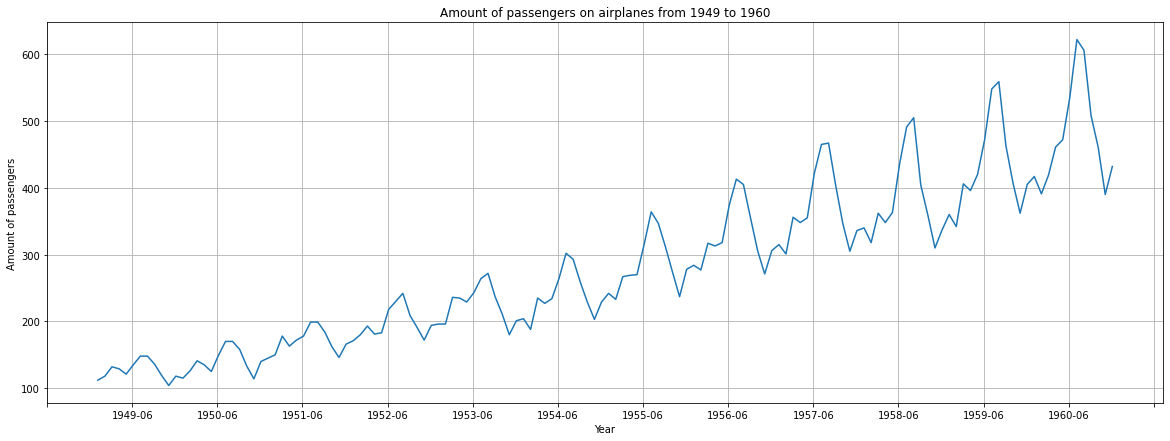

In [5]:

# ADF Test
result = adfuller(passengers_df.Passengers.values, autolag='AIC')
# print(f"Dickey-Fuller testy result: {result[0]}")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
# (link to source: https://analyticsindiamag.com/complete-guide-to-dickey-fuller-test-in-time-series-analysis/?fbclid=IwAR0_9LMa9MZzlJkLbjN6RC669pqJU8apxj4TUSy938AhNnp19r0X28FWMCM)



fig, ax = plt.subplots(figsize=(20, 7))
year_range = [int(str(x).split('-')[0]) for x in passengers_df.Month]


ax.plot(passengers_df.Month, passengers_df.Passengers)
ax.set_title("Amount of passengers on airplanes from 1949 to 1960")
ax.set_xlabel("Year")
ax.set_ylabel("Amount of passengers")
ax.grid(True)
plt.xticks(np.arange(min(year_range), max(year_range), 12.0))
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12))
plt.show()

Plotting by month looks to messy on the bottom, so I decided to go by year. With grid 'on' we can see that the behavior is cyclic, it repeats every year and we can see max value of passengers at about July, when everybody goes on vacation. Also the overall amount of airplane passengers grow every year. So both by dickey-fuller and visually we can conclude that this dataset is not stationary.

Then.. we make it stationary by... 'for trend, you can take the first difference'. k.

C:\Users\mpaka\AppData\Local\Temp\ipykernel_10500\1715124428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passengers_df["Untrended Passengers"][0] = int(passengers_df["Untrended Passengers"].mean())


-101 : 87


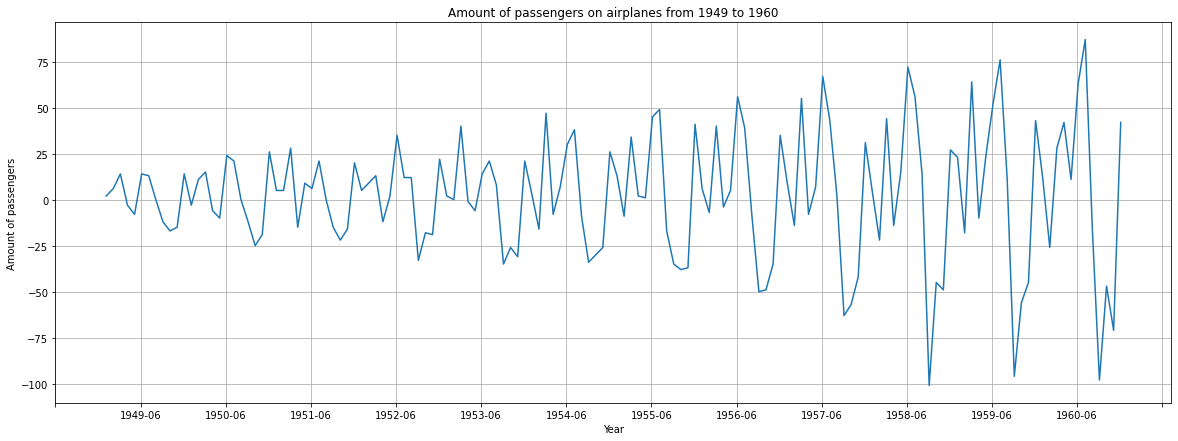

In [6]:
passengers_df["Untrended Passengers"] = passengers_df["Passengers"] - passengers_df["Passengers"].shift(1)
passengers_df["Untrended Passengers"][0] = int(passengers_df["Untrended Passengers"].mean())
# passengers_df["Untrended Passengers"]
fig, ax = plt.subplots(figsize=(20, 7))
# year_range = [float(str(x).split('-')[0]) for x in passengers_df['Untrended Passengers'] if pd.notna(x)]
year_range = []
for x in passengers_df['Untrended Passengers']:
    if pd.notna(x):
        year_range.append(int(x))
# print(year_range)
print(f"{min(year_range)} : {max(year_range)}")

ax.plot(passengers_df.Month, passengers_df['Untrended Passengers'])
ax.set_title("Amount of passengers on airplanes from 1949 to 1960")
ax.set_xlabel("Year")
ax.set_ylabel("Amount of passengers")
ax.grid(True)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 12))
plt.show()

I removed positive trend. k.

6. Split the data into training and test sets. Take the data from the very last year (1960) for the test set (i.e. the last 12 entries).  

In [7]:
test_12_last_months = passengers_df.iloc[132:]
train_the_rest = passengers_df.iloc[:132]

7. Create the index arrays for both train and test datasets. If you don’t remember how to do this from our ML class here is one example: train_idx = df.index <= train.index[-1], so just do the same for the test set.

In [8]:
test_ind_arr = passengers_df.index[132:]
train_ind_arr = passengers_df.index[:132]

8. Create the appropriate data structure for a time series analysis where the past 10 datapoints will be used to make predictions of the next 1 datapoint. 

In [9]:
past_gens = 10
def create_dataset(data,past_gens):
    x, y = [], []
    for i in range(len(data) - past_gens - 1):
        x.append(data[i:(i+past_gens)])
        y.append(data[i+past_gens])
    return np.array(x), np.array(y)

# test_data = test_12_last_months.Passengers.values
# test_data = test_data.astype('float32')
# #              without 'as float' it works wrong later. WELL THEN.
# train_data = train_the_rest.Passengers.values
# train_data = train_data.astype('float32')
#               I guess the above doesn't produce necessary format. WELL THEN.
pas_dataframe = pd.read_csv(os.getcwd() + '\\airline_passengers.csv', usecols=[1])

# ALMOST forgot about scaling. is that old saying that values between -1 - 0 - 1 still better? let's test.
scaler = MinMaxScaler(feature_range=(0, 1))

test_dataframe = pas_dataframe[132:].values
test_dataframe = test_dataframe.astype('float32')
test_dataframe = scaler.fit_transform(test_dataframe)
train_dataframe = pas_dataframe[:132].values
train_dataframe = train_dataframe.astype('float32')
train_dataframe = scaler.fit_transform(train_dataframe)

X_test, y_test = create_dataset(test_dataframe, past_gens)
X_train, y_train = create_dataset(train_dataframe, past_gens)

9. Reshape your created dataframe into the 3D format that RNN expects.
10. Create the X_train, y_train, X_test and y_test. (Does what we did earlier count?.. Like for y? I get X is reshaped, but y? )

In [10]:
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train

array([[[0.01758242, 0.03076923, 0.06153846, ..., 0.09670329,
         0.07032967, 0.03296703]],

       [[0.03076923, 0.06153846, 0.05494505, ..., 0.07032967,
         0.03296703, 0.        ]],

       [[0.06153846, 0.05494505, 0.03736264, ..., 0.03296703,
         0.        , 0.03076923]],

       ...,

       [[0.45274726, 0.51208794, 0.5626373 , ..., 0.8087913 ,
         0.97582424, 1.0000001 ]],

       [[0.51208794, 0.5626373 , 0.5230769 , ..., 0.97582424,
         1.0000001 , 0.789011  ]],

       [[0.5626373 , 0.5230769 , 0.66373634, ..., 1.0000001 ,
         0.789011  , 0.6659341 ]]], dtype=float32)

11. Create a one-layer LSTM with 25 units (neurons). Train it for 100 epochs with the default mini batch size of 32.
12. Compile and fit the model. When compiling, specify the ‘sgd’ optimizer, and choose the ‘accuracy’ metric to judge the goodness of your predictions. To compare further on the prediction results with the true values in the test set, specify inside the fit function your validation data: validation_data = (X_test, y_test). Save the history of the loss and the accuracy results in each epoch as the model is being trained, so that you can later on plot them and compare.

In [23]:
def create_sequential_model(layers, nodes, loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy']):
    model = Sequential()
    model.add(LSTM(nodes, input_shape=(1, past_gens)))
    for l in range(layers-1):
        model.add(Dense(nodes))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def run_a_model(x_train, x_test, y__train, y__test, layers, nodes, epochs, loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy']):
    nodes = int(nodes)
    layers = int (layers)
    epochs = int(epochs)
    model = create_sequential_model(layers, nodes, loss = loss, optimizer = optimizer, metrics = metrics)
    history = model.fit(x_train, y__train, epochs=100, validation_data=(x_test, y__test), batch_size=32, verbose=0)
    # return history
    print(f"Accuracy: {min(history.history['accuracy'])}")
    print(f"Loss: {min(history.history['loss'])}")
    print(f"Val Accuracy: {min(history.history['val_accuracy'])}")
    print(f"Val Loss : {min(history.history['val_loss'])}")

run_a_model(X_train, X_test, y_train, y_test, 1, 25, 100)
# history.history


    
# train_predict_pure = model.predict(trainX)
# test_predict_pure = model.predict(testX)

Accuracy: 0.00826446246355772
Loss: 0.11722742766141891
Val Accuracy: 1.0
Val Loss : 0.25655603408813477


In [ ]:


model = Sequential()
model.add(LSTM(25, input_shape=(1, past_gens)))
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100
4/4 [==============================] - 2s 134ms/step - loss: 2.0076 - accuracy: 0.0083 - val_loss: 2.1634 - val_accuracy: 1.0000
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 1.4628 - accuracy: 0.0083 - val_loss: 1.8976 - val_accuracy: 1.0000
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 1.1163 - accuracy: 0.0083 - val_loss: 1.6709 - val_accuracy: 1.0000
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8559 - accuracy: 0.0083 - val_loss: 1.4624 - val_accuracy: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6380 - accuracy: 0.0083 - val_loss: 1.2554 - val_accuracy: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4542 - accuracy: 0.0083 - val_loss: 1.0687 - val_accuracy: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3089 - accuracy: 0.0083 - val_loss: 0.9128 - val_accuracy: 1.0000
Epoch 8/100
4/4 [=====

Accuracy 0 is something. Great. I mean, I want to fully ignore any other data that I get because of this accuracy. What's the point?

I actually changed accuracy param and got SOME accuracy. I mean it is better than 0, right?

13. Plot the loss and accuracy in each epoch for the training set as well as the validation set. Comment on your results. Do you see signs of overfitting? If yes, explain. If no, explain.

soft overfitting because of slowly decreasing loss TODO

14. Do you see signs of vanishing or exploding gradient? Explain how the two would manifest in your graph. 

Slight vanishing.

Ok, so I need to plot it in the end

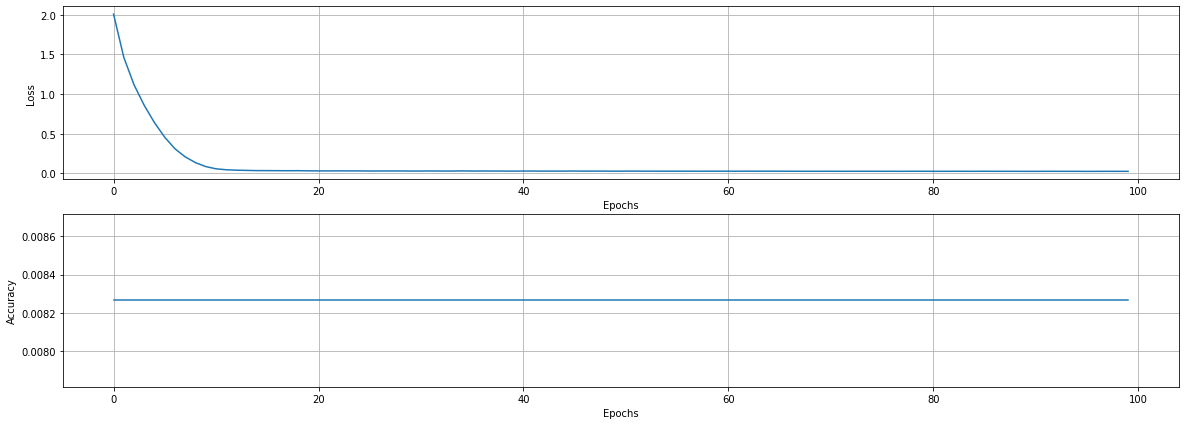

In [ ]:
fig, ax = plt.subplots(2,figsize=(20, 7))


ax[0].plot(history.epoch, history.history['loss'] )
# ax.set_title("Amount of passengers on airplanes from 1949 to 1960")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].grid(True)


ax[1].plot(history.epoch, history.history['accuracy'] )
# ax.set_title("Amount of passengers on airplanes from 1949 to 1960")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)

plt.show()



I can't really answer the question yet

15. Compute the model predictions, undo the differencing and plot the results.

Well, I guess if I didn't do it with 'Untrended Passengers' it is time to do it now. To repeat aaaaaall of the above... cool.
Do I even need the scaler then? I guess I do.

In [ ]:
pas_dataframe = pd.DataFrame(passengers_df['Untrended Passengers'])
scaler = MinMaxScaler(feature_range=(0, 1))

test_dataframe = pas_dataframe[132:].values
test_dataframe = test_dataframe.astype('float32')
test_dataframe = scaler.fit_transform(test_dataframe)
train_dataframe = pas_dataframe[:132].values
train_dataframe = train_dataframe.astype('float32')
train_dataframe = scaler.fit_transform(train_dataframe)

X_test, y_test = create_dataset(test_dataframe, past_gens)
X_train, y_train = create_dataset(train_dataframe, past_gens)

# ====/====/====/

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# ====/====/====/

model = Sequential()
model.add(LSTM(25, input_shape=(1, past_gens)))
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100
4/4 [==============================] - 2s 133ms/step - loss: 3.2821 - accuracy: 0.0000e+00 - val_loss: 1.5531 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 1.4695 - accuracy: 0.0000e+00 - val_loss: 1.4124 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 1.3162 - accuracy: 0.0083 - val_loss: 1.2697 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 1.1701 - accuracy: 0.0083 - val_loss: 1.1481 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 1.0103 - accuracy: 0.0083 - val_loss: 1.0452 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.8909 - accuracy: 0.0083 - val_loss: 0.9232 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7373 - accuracy: 0.0083 - val_loss: 0.8080 - val_accuracy

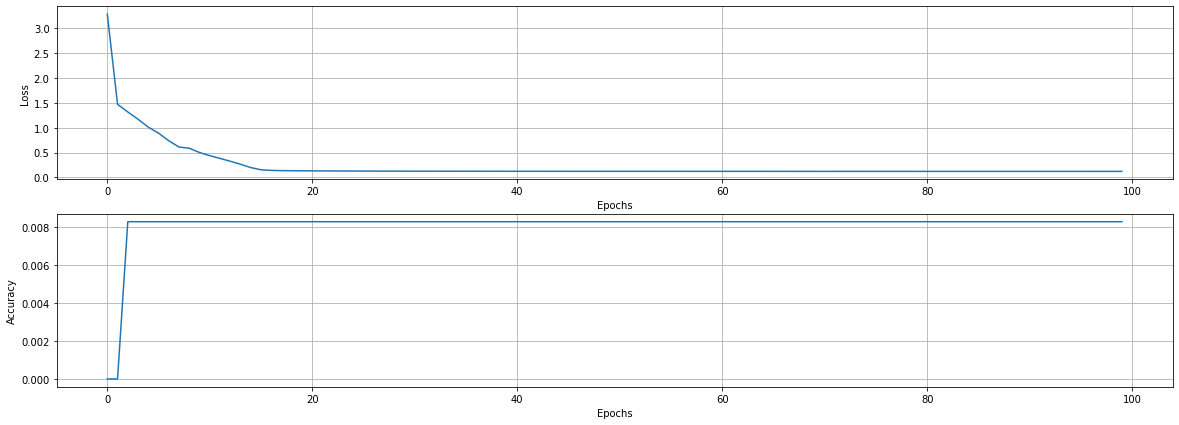

In [ ]:
fig, ax = plt.subplots(2,figsize=(20, 7))


ax[0].plot(history.epoch, history.history['loss'] )
# ax.set_title("Amount of passengers on airplanes from 1949 to 1960")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].grid(True)


ax[1].plot(history.epoch, history.history['accuracy'] )
# ax.set_title("Amount of passengers on airplanes from 1949 to 1960")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)

plt.show()

This looks a lot like we had in first try, likely because of scaler.

16. Now try other options and see if you can beat your initial predictions:

a) 500 epochs

In [ ]:
model = Sequential()
model.add(LSTM(25, input_shape=(1, past_gens)))
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/500
4/4 [==============================] - 2s 127ms/step - loss: 2.4448 - accuracy: 0.0000e+00 - val_loss: 1.3548 - val_accuracy: 0.0000e+00
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 1.3838 - accuracy: 0.0083 - val_loss: 1.2099 - val_accuracy: 0.0000e+00
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 1.2244 - accuracy: 0.0083 - val_loss: 1.0401 - val_accuracy: 0.0000e+00
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 1.0432 - accuracy: 0.0083 - val_loss: 0.8617 - val_accuracy: 0.0000e+00
Epoch 5/500
4/4 [==============================] - 0s 8ms/step - loss: 0.8415 - accuracy: 0.0083 - val_loss: 0.6923 - val_accuracy: 0.0000e+00
Epoch 6/500
4/4 [==============================] - 0s 11ms/step - loss: 0.6287 - accuracy: 0.0083 - val_loss: 0.5404 - val_accuracy: 0.0000e+00
Epoch 7/500
4/4 [==============================] - 0s 9ms/step - loss: 0.4304 - accuracy: 0.0083 - val_loss: 0.3972 - val_accuracy: 0.

 Vall loss and loss decreased, but accuracy is the same. I would stop at 100 epochs. ++ overfitting

b) Try two, three, and four  layers for your RNN with 50 and 100 neurons in each of the hidden layers (you should get altogether 6 models – 2 layers & 50 neurons, 2 layers & 100 neurons, 3 layers & 50 neurons, etc.). Train each of them for 100 epochs and save and plot the accuracies and the losses for each of the 6 combinations. Do you see signs of overfitting? Which model overfits most? Explain.

Well, in reality if the accuracy stays the same there is no sense plotting a thing. I can see accuracy even from log output.

In [ ]:
# 2 x 50
model1 = Sequential()
model1.add(LSTM(50, input_shape=(1, past_gens)))
model1.add(Dense(50))
model1.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history1 = model1.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# Loss is significantly lower with 2 layers.

Epoch 1/100
4/4 [==============================] - 2s 126ms/step - loss: 2.5369 - accuracy: 0.0000e+00 - val_loss: 1.0925 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1813 - accuracy: 0.0083 - val_loss: 0.9141 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9956 - accuracy: 0.0083 - val_loss: 0.6912 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7559 - accuracy: 0.0083 - val_loss: 0.4251 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.4815 - accuracy: 0.0083 - val_loss: 0.1768 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.2541 - accuracy: 0.0083 - val_loss: 0.0555 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.1528 - accuracy: 0.0083 - val_loss: 0.0252 - val_accuracy: 0.

In [ ]:
# 2 x 100
model2 = Sequential()
model2.add(LSTM(100, input_shape=(1, past_gens)))
model2.add(Dense(100))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# 100 nodes is too much, results are worse

Epoch 1/100
4/4 [==============================] - 2s 127ms/step - loss: 4.4958 - accuracy: 0.0000e+00 - val_loss: 1.5972 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 1.4540 - accuracy: 0.0083 - val_loss: 1.1916 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 1.1335 - accuracy: 0.0083 - val_loss: 1.0330 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0100 - accuracy: 0.0083 - val_loss: 0.9568 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9425 - accuracy: 0.0083 - val_loss: 0.9054 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.8928 - accuracy: 0.0083 - val_loss: 0.8643 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8531 - accuracy: 0.0083 - val_loss: 0.8304 - val_accuracy: 0

In [ ]:
# 3 x 50
model3 = Sequential()
model3.add(LSTM(50, input_shape=(1, past_gens)))
model3.add(Dense(50))
model3.add(Dense(50))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history3 = model3.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# nothing special

Epoch 1/100
4/4 [==============================] - 2s 129ms/step - loss: 4.7867 - accuracy: 0.0000e+00 - val_loss: 0.5541 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.2883 - accuracy: 0.0083 - val_loss: 0.1644 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0660 - accuracy: 0.0083 - val_loss: 0.0647 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.1982 - accuracy: 0.0083 - val_loss: 0.2805 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.1792 - accuracy: 0.0083 - val_loss: 0.0605 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0435 - accuracy: 0.0083 - val_loss: 0.1436 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0730 - accuracy: 0.0083 - val_loss: 0.0626 - val_accuracy: 

In [ ]:
# 3 x 100
model4 = Sequential()
model4.add(LSTM(100, input_shape=(1, past_gens)))
model4.add(Dense(100))
model4.add(Dense(100))
model4.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history4 = model4.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# not bad, but not better than previous results. ACCURACY IS STILL THE SAME. ugh.

Epoch 1/100
4/4 [==============================] - 2s 136ms/step - loss: 15.3182 - accuracy: 0.0000e+00 - val_loss: 15.4535 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 14.2282 - accuracy: 0.0083 - val_loss: 13.7238 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 13.2564 - accuracy: 0.0000e+00 - val_loss: 5.6291 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 3.1179 - accuracy: 0.0000e+00 - val_loss: 1.8604 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 1.8623 - accuracy: 0.0083 - val_loss: 1.4521 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 1.3938 - accuracy: 0.0083 - val_loss: 0.8462 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7176 - accuracy: 0.0083 - val_loss: 0.1583 - 

In [ ]:
# 4 x 50
model5 = Sequential()
model5.add(LSTM(50, input_shape=(1, past_gens)))
model5.add(Dense(50))
model5.add(Dense(50))
model5.add(Dense(50))
model5.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history5 = model5.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# terrible vall loss and loss, same accuracy. ignoring this, 4 layers are too much

Epoch 1/100
4/4 [==============================] - 2s 135ms/step - loss: 14.7221 - accuracy: 0.0000e+00 - val_loss: 17.7516 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 17.5215 - accuracy: 0.0000e+00 - val_loss: 17.4530 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 17.1622 - accuracy: 0.0000e+00 - val_loss: 16.8922 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 16.1722 - accuracy: 0.0000e+00 - val_loss: 12.7954 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 7.5818 - accuracy: 0.0000e+00 - val_loss: 2.8440 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 2.7831 - accuracy: 0.0083 - val_loss: 2.6777 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 2.6343 - accuracy: 0.0083 - val_loss: 2

In [ ]:
# 4 x 100
model6 = Sequential()
model6.add(LSTM(100, input_shape=(1, past_gens)))
model6.add(Dense(100))
model6.add(Dense(100))
model6.add(Dense(100))
model6.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history6 = model6.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

# terrible. I blame 4 layers.

Epoch 1/100
4/4 [==============================] - 2s 162ms/step - loss: 5.6072 - accuracy: 0.0000e+00 - val_loss: 2.9398 - val_accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 3.0179 - accuracy: 0.0083 - val_loss: 2.7392 - val_accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 2.7907 - accuracy: 0.0083 - val_loss: 2.4591 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 2.4644 - accuracy: 0.0083 - val_loss: 2.0142 - val_accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 11ms/step - loss: 1.9269 - accuracy: 0.0083 - val_loss: 1.4192 - val_accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 1.5294 - accuracy: 0.0083 - val_loss: 1.3863 - val_accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 11ms/step - loss: 1.5196 - accuracy: 0.0083 - val_loss: 1.3863 - val_accuracy:

c) For the most severely overfitting model from the 6 options above use the Dropuot in combination with the L2 method, to regularize your overfitting model. Be creative, try different options to correct for the overfit. 

Honestly, no clue how to do that for now

d) Could you create a model that beats the first one (the one with 1 layer and 25 units) and is not overfitting after regularization was applied?